In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


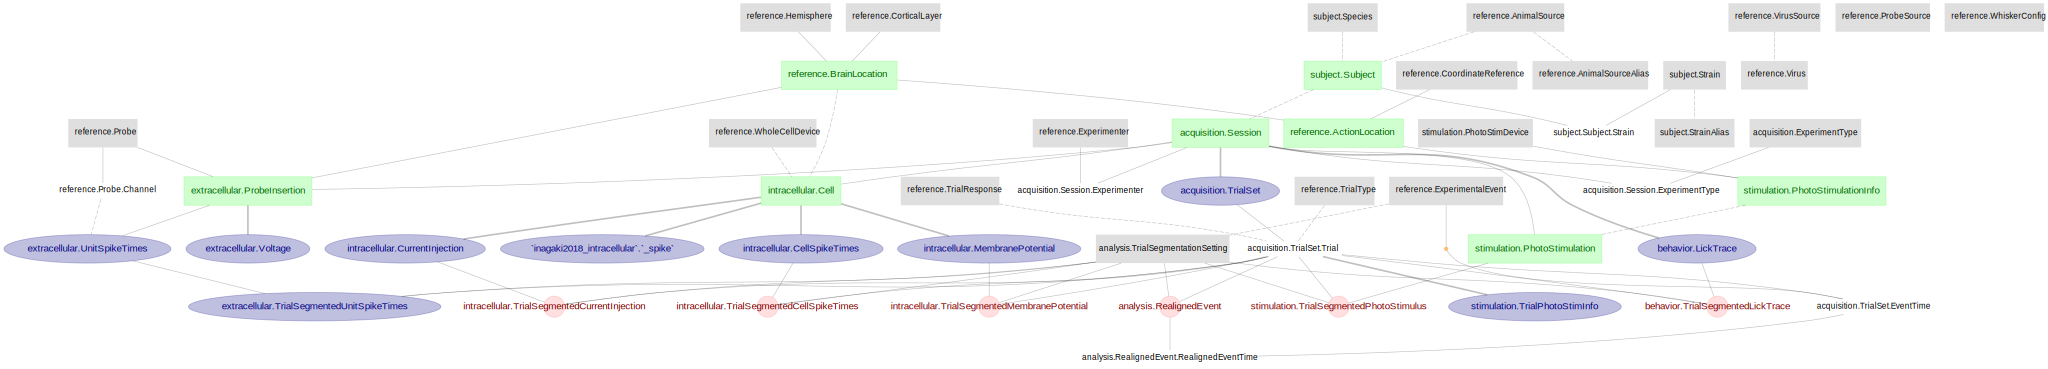

In [2]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproduce Figure 3a - whole-cell

In [4]:
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 3,
                                                      'post_stim_duration': 1}).fetch1()

In [49]:
contra_trials = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_is_good': True}
ipsi_trials = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_is_good': True}

In [6]:
cell_ids = [96, 120, 149]

In [7]:
cells = {f'cell_{c}': {'w_current_injection': ((intracellular.Cell & {'cell_id': f'cell_{c}'}) 
                                                  & (acquisition.Session.ExperimentType & {'experiment_type': 'EPSP'})).fetch('KEY'),
                         'wo_current_injection': ((intracellular.Cell & {'cell_id': f'cell_{c}'})
                                                 & (acquisition.Session.ExperimentType & {'experiment_type': 'regular'})).fetch('KEY')} 
           for c in cell_ids}

In [11]:
for k, v in cells.items():
    cells[k]['type'] = (acquisition.Session.ExperimentType & v['w_current_injection']).fetch('experiment_type')

In [26]:
def query_segmented_intracellular(cell_key, trial_key, seg_param_key):
    data_keys = (intracellular.TrialSegmentedMembranePotential & cell_key & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key))
    return [{**dict(zip(['segmented_mp', 'segmented_mp_wo_spike'],
                        (analysis.TrialSegmentedIntracellular.MembranePotential & k).fetch1(
                            'segmented_mp', 'segmented_mp_wo_spike'))),
             **dict(zip(*(acquisition.TrialSet.RealignedEventTime & k).fetch(
                 'realigned_trial_event', 'realigned_event_time')))}
            for k in data_keys]

In [72]:
cell_key = cells['cell_96']['wo_current_injection']
tmp = query_segmented_intracellular(cell_key, contra_trials, seg_param_key)


In [73]:
(intracellular.TrialSegmentedMembranePotential & cell_key & seg_param_key) * (acquisition.TrialSet.Trial)

session_id,cell_id a string identifying the cell in which this intracellular recording is concerning,trial_id id of this trial in this trial set,trial_seg_setting,segmented_mp,segmented_mp_wo_spike,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,trial_is_good good/bad status of trial (bad trials are not analyzed),delay_duration (s) duration of the delay period
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,3,0,=BLOB=,=BLOB=,27.7869,34.9299,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,4,0,=BLOB=,=BLOB=,35.8335,42.0325,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,5,0,=BLOB=,=BLOB=,43.1615,49.4415,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,9,0,=BLOB=,=BLOB=,75.7388,82.8284,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,11,0,=BLOB=,=BLOB=,92.2697,99.497,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,12,0,=BLOB=,=BLOB=,100.332,106.599,lick left,correct,0,1,1.2
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,14,0,=BLOB=,=BLOB=,115.753,123.196,lick left,correct,0,1,1.2


In [74]:
intracellular.TrialSegmentedMembranePotential & 'cell_id="cell_96"'

session_id,cell_id a string identifying the cell in which this intracellular recording is concerning,trial_id id of this trial in this trial set,trial_seg_setting,segmented_mp,segmented_mp_wo_spike
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,3,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,4,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,5,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,9,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,11,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,12,0,=BLOB=,=BLOB=
89b1b2a624734e4e8fa6e4b8f8112f88,cell_96,14,0,=BLOB=,=BLOB=


In [43]:
(acquisition.TrialSet.Trial & contra_trials)

session_id,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,trial_is_good good/bad status of trial (bad trials are not analyzed),delay_duration (s) duration of the delay period
0835bd1ca0614b07aeebadc21d8552bf,5,44.6741,51.5256,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,6,52.377,59.5165,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,15,125.031,131.811,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,16,132.766,139.105,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,18,148.515,155.151,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,20,163.921,171.442,lick right,correct,0,1,1.2
0835bd1ca0614b07aeebadc21d8552bf,22,180.405,187.262,lick right,correct,0,1,1.2


In [63]:
set(intracellular.TrialSegmentedMembranePotential.fetch('cell_id'))

{'cell_100',
 'cell_101',
 'cell_103',
 'cell_105',
 'cell_109',
 'cell_110',
 'cell_114',
 'cell_117',
 'cell_118',
 'cell_119',
 'cell_124',
 'cell_125',
 'cell_128',
 'cell_130',
 'cell_131',
 'cell_133',
 'cell_135',
 'cell_136',
 'cell_138',
 'cell_139',
 'cell_148',
 'cell_149',
 'cell_150',
 'cell_151',
 'cell_152',
 'cell_156',
 'cell_158',
 'cell_166',
 'cell_168',
 'cell_169',
 'cell_170',
 'cell_177',
 'cell_178',
 'cell_182',
 'cell_183',
 'cell_184',
 'cell_88',
 'cell_91',
 'cell_92',
 'cell_94',
 'cell_96',
 'cell_98',
 'cell_99'}

In [10]:
cell_mps = {cell: {'w_current_injection': {'contra': (intracellular.TrialSegmentedMembranePotential 
                                                      & c_val['w_current_injection'] & seg_param_key & contra_trials),
                                           'ipsi': {}},
                   'wo_current_injection': {'contra': {},
                                           'ipsi': {}}
                  } for cell, c_val in cells.items}

TypeError: 'builtin_function_or_method' object is not iterable